In [ ]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [ ]:
class Cifar10(torchvision.datasets.CIFAR10):
  def __init__(self, train: bool):
    super().__init__(root='~/data', train=train, download=True)
    self.data = self.data.astype(np.float32) / 255 - 0.5  # data normalization

  def __getitem__(self, idx):
    return self.data[idx], self.targets[idx]

data_train = Cifar10(train=True)
data_train, data_valid = torch.utils.data.random_split(data_train, (45000, 5000))
data_test = Cifar10(train=False)

Extracting /root/data/cifar-10-python.tar.gz to /root/data
Files already downloaded and verified


In [ ]:
kwargs = {'batch_size': 100, 'num_workers': 2}
loader_train = torch.utils.data.DataLoader(data_train, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(data_valid, **kwargs)
loader_test = torch.utils.data.DataLoader(data_test, **kwargs)

# Challenge
* Build a Multi Layer Perceptron, MLP, with one ReLU-activated hidden layer.
* Use the validation set to inform e.g. number of hidden neurons.
* When you're satisfied, then, use the test set to get an  
unbiased estimate of your models performance on the real data distribution.

In [ ]:
# by extending nn.Module:
class MLP(nn.Module):
  def __init__(self, n_hidden_neurons: int):
    super().__init__()
    self.fc1 = nn.Linear(32 * 32 * 3, n_hidden_neurons)
    self.fc2 = nn.Linear(n_hidden_neurons, 10)

  def forward(self, x: torch.Tensor):
    x = x.flatten(start_dim=1)  # (N, d_data)
    h = F.relu(self.fc1(x))
    logits = self.fc2(h)
    return logits

In [ ]:
# or, as an nn.Sequential module:
def build_mlp(n_hidden_neurons: int):
  return nn.Sequential(
      nn.Flatten(start_dim=1),  # (N, d_data)
      nn.Linear(32 * 32 * 3, n_hidden_neurons), nn.ReLU(),
      nn.Linear(n_hidden_neurons, 10)
  )

In [ ]:
all_losses, all_accuracies = {}, {}
best_accuracy = 0
best_model = None

In [ ]:
device = torch.device('cuda')
for n_hidden_neurons in (10, 100, 1000, 10000):
  model = build_mlp(n_hidden_neurons).to(device)
  opt = torch.optim.SGD(model.parameters(), lr=5e-2)

  train_losses, train_accuracies = [], []
  valid_losses, valid_accuracies = [], []

  for epoch in tqdm(range(50)):
    # train
    epoch_losses = []
    correct, total = 0, 0
    for x, y in loader_train:
      opt.zero_grad()
      x, y = x.to(device), y.to(device)
      logits = model(x)  # logits: common name for the output before softmax activation
      log_probs = F.log_softmax(logits, dim=1)  # numerically stable version of log(softmax(logits))
      loss = F.nll_loss(log_probs, y)  # negative log likelihood loss
      # or just: loss = F.cross_entropy(logits, y)

      loss.backward()
      opt.step()

      epoch_losses.append(loss.item())
      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    train_losses.append(np.mean(epoch_losses))
    train_accuracies.append(correct / total)

    # valid
    epoch_losses = []
    correct, total = 0, 0
    for x, y in loader_valid:
      x, y = x.to(device), y.to(device)
      # Performance tip: we don't want to update weights
      # based on the validation set, so we don't need
      # pytorch to keep track of gradients here
      with torch.no_grad():
        logits = model(x)
      loss = F.cross_entropy(logits, y)

      epoch_losses.append(loss.item())
      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    valid_losses.append(np.mean(epoch_losses))
    valid_accuracy = correct / total
    valid_accuracies.append(valid_accuracy)

    if valid_accuracy > best_accuracy:
      best_accuracy = valid_accuracy
      best_model = copy.deepcopy(model), n_hidden_neurons, epoch

  all_losses[n_hidden_neurons] = train_losses, valid_losses
  all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies

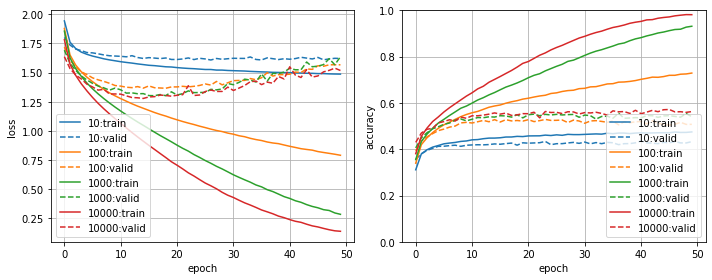

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
for n, (train_losses, valid_losses) in all_losses.items():
  p = plt.plot(train_losses, label=f'{n}:train')
  plt.plot(valid_losses, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
for n, (train_accuracies, valid_accuracies) in all_accuracies.items():
  p = plt.plot(train_accuracies, label=f'{n}:train')
  plt.plot(valid_accuracies, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# test
model, n_hidden_neurons, epoch = best_model
print(f'best val accuracy: {best_accuracy:.2f} with {n_hidden_neurons} hidden neurons after {epoch} epoch')

correct, total = 0, 0
for x, y in loader_valid:
  x, y = x.to(device), y.to(device)
  with torch.no_grad():
    logits = model(x)
  total += len(x)
  correct += (torch.argmax(logits, dim=1) == y).sum().item()
print(f'test accuracy: {correct / total:.2f}')

best val accuracy: 0.57 with 10000 hidden neurons after 45 epoch
test accuracy: 0.57


### A note on overfitting
You may find different interpretations of what overfitting is, including:

* The gap between training loss and validation loss
* When the validation loss starts rising (around epoch 15-20 above)
* The gap between training accuracy and validation accuracy
* When the validation error (here, 1 - accuracy) starts rising (doesn't really happen here, presumably because we're dealing with small models)

In all cases though, it refers to the model learnings something from the training dataset that doesn't generalize to the validation dataset, and we don't really want that.

In lecture 6, we'll look at how to reduce overfitting.